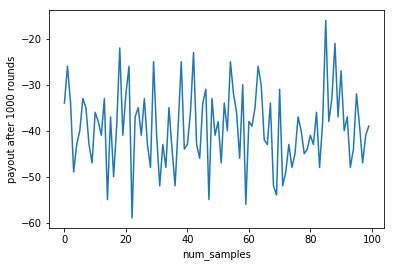

Average payout after 100 rounds is -39.19


In [90]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
env.seed(0)
env.reset()

num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

average_payouts = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
#         print('ACTION: ' + str(action))
        
        obs, payout, is_done, info = env.step(action)
#         print('OBS: ' + str(obs))
#         print('PAYOUT: ' + str(payout))
#         print('ID_DONE: ' + str(is_done))
#         print('INFO: ' + str(info))

        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

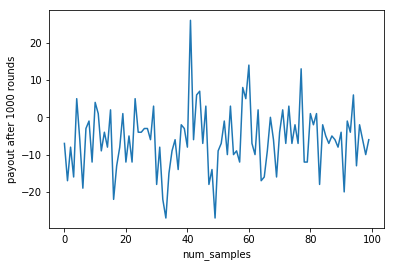

Average payout after 100 rounds is -5.94


In [91]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*10 # 2 to 11
    actions.append([1]*2 + [0]*3 + [1]*5) #12
    actions.extend([[0]*6 + [1]*4]*4) #13-16
    actions.extend([[0]*10]*5) #17-21
    
#     for x in actions:
#         print(x)
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
# assert (normal_strategy(15, 2)) == 0
# assert (normal_strategy(15, 1)) == 1


num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples
total_payout = 0 # to store total payout over 'num_rounds'

average_payouts = []

for x in range(num_samples):
    round = 1
    round_payout = 0
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
#         print(player_sum)
#         print(dealer_up_card)
#         print(normal_strategy(player_sum, dealer_up_card))
        
        
        obs, payout, is_done, _ = env.step(action)
        round_payout += payout
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(round_payout)

    
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))


In [1]:
import random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
import pandas as pd

random.seed(0)

class DQNAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, time = 30000):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = env.observation_space
        self.memory = deque(maxlen=2000) # Record past experiences- [(state, action, reward, next_state, done)...]
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning = True
        self.model = self._build_model()
        
        self.time = time 
        self.time_left = time # Epsilon Decay
        self.small_decrement = (0.4 * epsilon) / (0.3 * self.time_left) # reduce epsilon
        print('HELLO')
    
    # Build Neural Net
    def _build_model(self):
#         print(type(self.state_size))
        model = Sequential()
        model.add(Dense(32, input_shape = (2,), kernel_initializer='random_uniform', activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.alpha))
        
        return model
       
#     # Remember function that stores states, actions, rewards, and done to memory
#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append([state, action, reward, next_state, done])

    def choose_action(self, state):
        """
        Choose which action to take, based on the observation. 
        Uses greedy epsilon for exploration/exploitation.
        """

        # if random number > epsilon, act 'rationally'. otherwise, choose random action
        
        if np.random.rand() <= self.epsilon:
#             print(np.random.rand())
#             print(self.epsilon)
#             print('random')
#             print('-------')
            
            action = random.randrange(self.action_size)
#             print('random: ' + str(action))

            
        else:
#             print('logic')

            action_value = self.model.predict(state)
#             print(action_value)
#             print(action_value)
#             print(action_value)
#             print('-------')
            action = np.argmax(action_value[0])
#             print(action)
        
        self.update_parameters()
        return action
        
    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
#         print(self.time_left)
        if self.time_left > 0.9 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.7 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.5 * self.time:
            self.epsilon -= self.small_decrement
#             print('0.5')
        elif self.time_left > 0.3 * self.time:
#             print('0.2')
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.1 * self.time:
            self.epsilon -= self.small_decrement
#         elif self.time_left < 0.05 * self.time:
#             self.epsilon = 0.000
#             self.learning = False

#         print(self.time_left)
        #         print(self.time)
        self.time_left -= 1       


    def learn(self, state, action, reward, next_state, done):
        
        
        
#         minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
        
        target = reward
#         print('STATE: ' + str(state))
#             print('next_state: ' + str(state))

#         print('target: ' + str(target))

        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

#         print('target: ' + str(target))


#         print('action: ' + str(action))
#             print(self.model.predict(next_state))
#         print(np.amax(self.model.predict(next_state)[0]))

        target_f = self.model.predict(state)
#         print(target_f)
#         print('target_f: ' + str(target_f))


        target_f[0][action] = target
#         print('target_f: ' + str(target_f))
#             print('target_f: ' + str(target_f))
#         print('-------')

        self.model.fit(state, target_f, epochs=1, verbose=0)
        
        
#             print(self.time)
#         print(self.epsilon)

    def get_optimal_strategy(self):
        index = []
        for x in range(0,21):
            for y in range(1,11):
                index.append((x,y))

        df = pd.DataFrame(index = index, columns = ['Stand', 'Hit'])

        for ind in index:
            outcome = self.model.predict([np.array([ind])], batch_size=1)
            df.loc[ind, 'Stand'] = outcome[0][0]
            df.loc[ind, 'Hit'] = outcome[0][1]


        df['Optimal'] = df.apply(lambda x : 'Hit' if x['Hit'] >= x['Stand'] else 'Stand', axis=1)
        df.to_csv('optimal_policy.csv')
        return df


Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import gym
env = gym.make('Blackjack-v0')
env.seed(0)
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 100 # Payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1.0, alpha=0.001, gamma=0.1, time=7500)

average_payouts = []

state = env.reset()
state = np.reshape(state[0:2], [1,2])
for sample in range(num_samples):
    round = 1
    total_payout = 0 # store total payout per sample
    while round <= num_rounds:
        action = agent.choose_action(state)
        next_state, payout, done, _ = env.step(action)
        next_state = np.reshape(next_state[0:2], [1,2])

        
        total_payout += payout    
#         if agent.learning:
        agent.learn(state, action, payout, next_state, done)
        
        state = next_state
        state = np.reshape(state[0:2], [1,2])
        
        if done:
            state = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state[0:2], [1,2])
            round += 1

    average_payouts.append(total_payout)

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)

print(agent.get_optimal_strategy())

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

HELLO
Done with sample: 0   --- 1.25105619430542 seconds ---
0.9765333333333261
Done with sample: 10   --- 4.252377033233643 seconds ---
0.7333333333332517
Done with sample: 20   --- 7.411294221878052 seconds ---
0.4965333333331803
Done with sample: 30   --- 10.625895261764526 seconds ---
0.2520888888887373
Done with sample: 40   --- 14.332590103149414 seconds ---
-0.001244444444594608
             Stand       Hit Optimal
(0, 1)    0.492666  0.507334     Hit
(0, 2)    0.489836  0.510164     Hit
(0, 3)    0.486764  0.513236     Hit
(0, 4)     0.48338   0.51662     Hit
(0, 5)    0.479975  0.520025     Hit
(0, 6)     0.47605   0.52395     Hit
(0, 7)    0.472127  0.527873     Hit
(0, 8)    0.468209  0.531792     Hit
(0, 9)    0.464294  0.535706     Hit
(0, 10)   0.460383  0.539617     Hit
(1, 1)    0.495587  0.504413     Hit
(1, 2)    0.495767  0.504233     Hit
(1, 3)    0.493247  0.506753     Hit
(1, 4)    0.490917  0.509083     Hit
(1, 5)    0.488386  0.511614     Hit
(1, 6)    0.485492 

Average payout after 100 rounds is -21.8
